In [2]:
import numpy as np
import pandas as pd
from functions import *
from schemes import *
from plot import * 
from Kepler import *
from adaptive import *
from FRSolver import * 

%matplotlib inline

In [3]:
# gravity
G = 1

m1 = 1 
m2 = 1 
m3 = 1

R = 1

# position
r1 = np.array([-R,0.0,0.0], dtype="float64")
r2 = np.array([0,0.0,0.0], dtype="float64")
r3 = np.array([R,0.0,0.0], dtype="float64")

px = 0.347111
py = 0.532728

# velocity 
v1 = np.array([px,py,0], dtype="float64")
v2 = np.array([-2 * px,-2*py,0], dtype="float64")
v3 = np.array([px,py,0], dtype="float64")

# create initial vectors
r0s = np.array([r1,r2,r3])
v0s = np.array([v1,v2,v3])
masses = np.array([m1, m2, m3])

In [4]:
T = 1000
hlim = 0.01
Elim = 0.01
C = 0.3

In [5]:
def findmassR(v0s, E0, masses):
    ke = np.sum(KineticEnergy(v0s, masses))
    R = (2 * masses[0] + masses[0] * masses[2] + 2 * masses[2]) / (2 * (ke - E0))
    return R

In [6]:
dm1s = np.linspace(-0.0002,0.0002,101)
dm3s = np.flip(np.linspace(-0.0002, 0.0002,101))

print(dm1s, dm3s)

[-2.00000000e-04 -1.96000000e-04 -1.92000000e-04 -1.88000000e-04
 -1.84000000e-04 -1.80000000e-04 -1.76000000e-04 -1.72000000e-04
 -1.68000000e-04 -1.64000000e-04 -1.60000000e-04 -1.56000000e-04
 -1.52000000e-04 -1.48000000e-04 -1.44000000e-04 -1.40000000e-04
 -1.36000000e-04 -1.32000000e-04 -1.28000000e-04 -1.24000000e-04
 -1.20000000e-04 -1.16000000e-04 -1.12000000e-04 -1.08000000e-04
 -1.04000000e-04 -1.00000000e-04 -9.60000000e-05 -9.20000000e-05
 -8.80000000e-05 -8.40000000e-05 -8.00000000e-05 -7.60000000e-05
 -7.20000000e-05 -6.80000000e-05 -6.40000000e-05 -6.00000000e-05
 -5.60000000e-05 -5.20000000e-05 -4.80000000e-05 -4.40000000e-05
 -4.00000000e-05 -3.60000000e-05 -3.20000000e-05 -2.80000000e-05
 -2.40000000e-05 -2.00000000e-05 -1.60000000e-05 -1.20000000e-05
 -8.00000000e-06 -4.00000000e-06 -2.71050543e-20  4.00000000e-06
  8.00000000e-06  1.20000000e-05  1.60000000e-05  2.00000000e-05
  2.40000000e-05  2.80000000e-05  3.20000000e-05  3.60000000e-05
  4.00000000e-05  4.40000

In [19]:
E0 = TotalEnergy(r0s, v0s, G, masses)
print(E0)
stabilities = []
ts = []
Es = []
variances = []
for dm1 in dm1s:
    for dm3 in dm3s:
        print(dm1, dm3)
        m1hat = m1 + dm1
        m3hat = m3 + dm3

        masseshat = np.array([m1hat, m2, m3hat])

        R = findmassR(v0s, E0, masseshat)
        
        # position
        r1hat = np.array([-R,0.0,0.0], dtype="float64")
        r2hat = np.array([0,0.0,0.0], dtype="float64")
        r3hat = np.array([R,0.0,0.0], dtype="float64")
        r0shat = np.array([r1hat,r2hat,r3hat])

        stability, variance, maxE, escapet = shapeSolver(T, C, r0shat, v0s, G, masseshat, hlim = 0.01)

        variances.append(variance)
        stabilities.append(stability)
        ts.append(escapet)
        Es.append(maxE)

stabilities = np.array(stabilities).reshape(len(dm1s), len(dm3s))
Es = np.array(stabilities).reshape(len(dm1s), len(dm3s))
ts = np.array(ts).reshape(len(dm1s), len(dm3s))
variances = np.array(variances).reshape(len(dm1s), len(dm3s))

-1.287144495085
-0.0002 0.0002
-0.0002 0.00019599999999999997
-0.0002 0.00019199999999999998
-0.0002 0.000188
-0.0002 0.000184
-0.0002 0.00017999999999999996
-0.0002 0.00017599999999999997
-0.0002 0.00017199999999999998
-0.0002 0.000168
-0.0002 0.00016399999999999995
-0.0002 0.00015999999999999996
-0.0002 0.00015599999999999997
-0.0002 0.00015199999999999998
-0.0002 0.000148
-0.0002 0.00014399999999999995
-0.0002 0.00013999999999999996
-0.0002 0.00013599999999999997
-0.0002 0.00013199999999999998
-0.0002 0.000128
-0.0002 0.00012399999999999995
-0.0002 0.00011999999999999996
-0.0002 0.00011599999999999997
-0.0002 0.00011199999999999998
-0.0002 0.000108
-0.0002 0.00010399999999999995
-0.0002 9.999999999999996e-05
-0.0002 9.599999999999998e-05
-0.0002 9.199999999999999e-05
-0.0002 8.8e-05
-0.0002 8.399999999999995e-05
-0.0002 7.999999999999997e-05
-0.0002 7.599999999999998e-05
-0.0002 7.199999999999999e-05
-0.0002 6.8e-05
-0.0002 6.399999999999996e-05
-0.0002 5.999999999999997e-05
-0.0002

In [37]:
import pandas as pd 
df = pd.DataFrame(stabilities)
df.to_csv("Data/Fig8/Mass/MassStability.csv")

df = pd.DataFrame(Es)
df.to_csv("Data/Fig8/Mass/MassStability_Energy.csv")

df = pd.DataFrame(ts)
df.to_csv("Data/Fig8/Mass/MassStability_ts.csv")

df = pd.DataFrame(variances)
df.to_csv("Data/Fig8/Mass/MassVariance_ts.csv")

NameError: name 'stabilities' is not defined

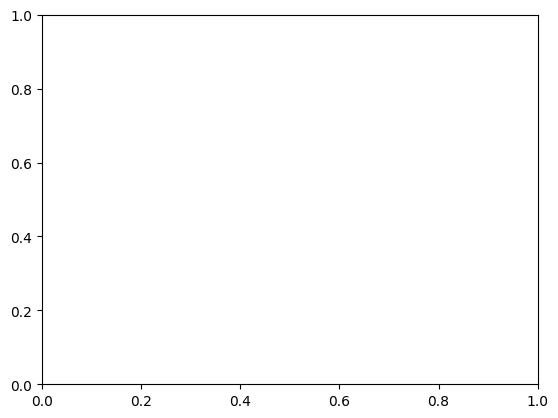

In [7]:
import seaborn as sns
from matplotlib.colors import ListedColormap


# Create a figure and axis for the heatmap
fig, ax = plt.subplots()

cmap = ListedColormap(['orangered','mediumspringgreen','salmon','papayawhip'])
# cmap = sns.color_palette('tab10', n_colors=4)

# Create the heatmap using Seaborn
sns.heatmap(stabilities.T,cmap = cmap,  cbar=True, ax=ax, vmin=0, vmax=3)

# Determine the tick positions
num_ticks = 5
tick_positions = np.linspace(0, stabilities.shape[0] - 1, num_ticks, dtype=int) 

# Set the tick positions and labels for both x-axis and y-axis
ax.set_xticks(tick_positions + 0.5)
ax.set_yticks(tick_positions + 0.5)
ax.set_xticklabels(np.round(dm1s, 5)[tick_positions])
ax.set_yticklabels(np.round(dm3s, 5)[tick_positions])

# Set axis labels and title
ax.set_xlabel(f'$\delta v_x$')
ax.set_ylabel('$\delta v_y$')

colorbar = ax.collections[0].colorbar
colorbar.set_ticks(0.375 * np.array([1, 3, 5, 7]))
colorbar.set_ticklabels(['$d > 10$', '$T > {1000}}$', '$h < 0.001$', '$E > 0.01$'])

# Show the plot
plt.show()


In [13]:

variances = np.array(pd.read_csv("Data/Fig8/Mass/MassVariance_ts.csv"))[:,1:]

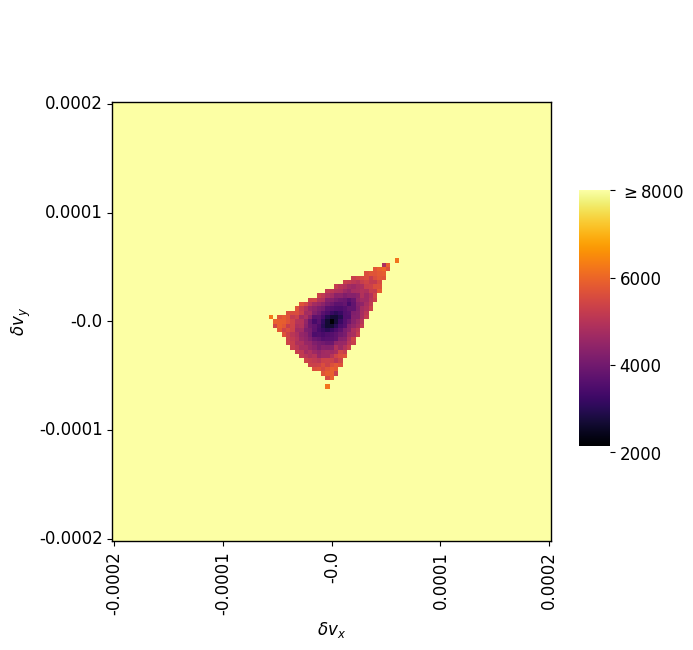

In [22]:
import seaborn as sns
from matplotlib.colors import ListedColormap


# Create a figure and axis for the heatmap
fig, ax = plt.subplots(figsize = (7,7))

# Create the heatmap using Seaborn
res = sns.heatmap(variances.T,cmap = 'inferno',  cbar=True, ax=ax, vmax = 8000)

# Determine the tick positions
num_ticks = 5
tick_positionsx = np.linspace(0, variances.shape[0] - 1, num_ticks, dtype=int) 
tick_positionsy = np.linspace(0, variances.shape[1] - 1, num_ticks, dtype=int) 

# Set the tick positions and labels for both x-axis and y-axis
ax.set_xticks(tick_positionsx + 0.5)
ax.set_yticks(tick_positionsy + 0.5)
ax.set_xticklabels(np.round(dm1s,5)[tick_positionsx], fontsize = 12)
ax.set_yticklabels(np.round(dm3s,5)[tick_positionsy], fontsize = 12)

# Set axis labels and title
ax.set_xlabel(f'$\delta v_x$', fontsize = 12)
ax.set_ylabel('$\delta v_y$', fontsize = 12)

colorbar = ax.collections[0].colorbar
colorbar.set_ticks([2000,4000,6000,8000])
colorbar.set_ticklabels(['2000','4000','6000',r'$\geq 8000$'], fontsize = 12)

# Drawing the frame
for _, spine in res.spines.items():
    spine.set_visible(True)
    spine.set_linewidth(1)

ax.set_aspect('equal')
colorbar.ax.set_aspect(0.0014)
plt.tight_layout()

plt.savefig('Plots/3Body/Fig8/MassVariance.png')


In [27]:
# gravity
G = 1

m1 = 1 
m2 = 1 
m3 = 1

R = 1

# position
r1 = np.array([-R,0.0,0.0], dtype="float64")
r2 = np.array([0,0.0,0.0], dtype="float64")
r3 = np.array([R,0.0,0.0], dtype="float64")

px = 0.347111
py = 0.532728

# velocity 
v1 = np.array([px,py,0], dtype="float64")
v2 = np.array([-2 * px,-2*py,0], dtype="float64")
v3 = np.array([px,py,0], dtype="float64")

# create initial vectors
r0s = np.array([r1,r2,r3])
v0s = np.array([v1,v2,v3])
masses = np.array([m1, m2, m3])

E0 = TotalEnergy(r0s, v0s, G, masses)

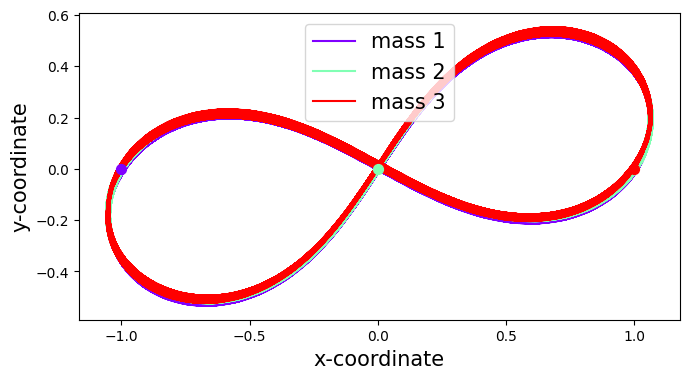

In [28]:
PlotOrbits(traj)

In [34]:
m_vals = np.linspace(-0.0002, 0.0002, 100)

variances = []
trajectories = []
for dm in m_vals:
    masseshat = np.array([m1, m2+dm, m3])

    R = findmassR(v0s, E0, masseshat)

    # position
    r1hat = np.array([-R,0.0,0.0], dtype="float64")
    r2hat = np.array([0,0.0,0.0], dtype="float64")
    r3hat = np.array([R,0.0,0.0], dtype="float64")
    r0shat = np.array([r1hat,r2hat,r3hat])

    traj, stability = fullSolver(T, C, r0shat, v0s, G, masseshat, hlim = 1e-5)

    stabilities.append(stability)
    trajectories.append(traj)



In [39]:
variances = []
for i, traj in enumerate(trajectories):
    if stabilities[i] == 1:
        path = np.array([distCalculator(rs) for rs in traj[1]])
        grid = fillGrid(path, gridsize = 500)
        variances.append(np.sum(grid))
    else:
        variances.append(10000)


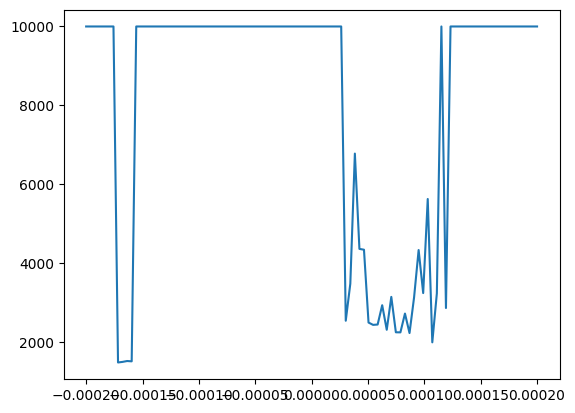

In [40]:
plt.plot(m_vals, variances)